In [4]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

import numpy as np
import random

import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

# Process the data, normalize it, reshape it, and one-hot-encode the labels
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


In [5]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

model = create_model()

In [6]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0196 - accuracy: 0.8640 - val_loss: 0.0067 - val_accuracy: 0.9548
Epoch 2/20
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0093 - accuracy: 0.9391 - val_loss: 0.0049 - val_accuracy: 0.9679
Epoch 3/20
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0073 - accuracy: 0.9532 - val_loss: 0.0043 - val_accuracy: 0.9710
Epoch 4/20
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0067 - accuracy: 0.9571 - val_loss: 0.0042 - val_accuracy: 0.9722
Epoch 5/20
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0058 - accuracy: 0.9624 - val_loss: 0.0035 - val_accuracy: 0.9773
Epoch 6/20
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0055 - accuracy: 0.9649 - val_loss: 0.0039 - val_accuracy: 0.9740
Epoch 7/20
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0050 - accuracy: 0.9685 - val_loss: 0.0039 -

In [7]:
print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Base accuracy on regular images: [0.00320904771797359, 0.9807999730110168]


In [8]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

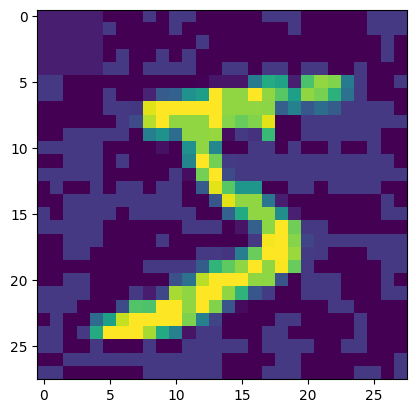

In [9]:
# Creating an Example Adversarial Image
image = x_train[0]
image_label = y_train[0]
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
adversarial = image + perturbations * 0.1
if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()

In [10]:
print(labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print(labels[model.predict(adversarial).argmax()])

1/1 [==============================] - 0s 114ms/step
five
1/1 [==============================] - 0s 20ms/step
three


In [11]:
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

In [12]:
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))
print("Base accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Base accuracy on adversarial images: [0.1501842588186264, 0.2003999948501587]


In [13]:
x_adversarial_train, y_adversarial_train = next(generate_adversarials(20000))
model.fit(x_adversarial_train, y_adversarial_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test))
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))
print("Defended accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Epoch 1/10
625/625 [==============================] - 9s 15ms/step - loss: 0.0105 - accuracy: 0.9430 - val_loss: 0.0097 - val_accuracy: 0.9453
Epoch 2/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0028 - accuracy: 0.9853 - val_loss: 0.0102 - val_accuracy: 0.9431
Epoch 3/10
625/625 [==============================] - 9s 14ms/step - loss: 0.0020 - accuracy: 0.9899 - val_loss: 0.0120 - val_accuracy: 0.9325
Epoch 4/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0019 - accuracy: 0.9902 - val_loss: 0.0118 - val_accuracy: 0.9347
Epoch 5/10
625/625 [==============================] - 9s 14ms/step - loss: 0.0018 - accuracy: 0.9903 - val_loss: 0.0114 - val_accuracy: 0.9365
Epoch 6/10
625/625 [==============================] - 10s 15ms/step - loss: 9.8117e-05 - accuracy: 0.9993 - val_loss: 0.0116 - val_accuracy: 0.9359
Epoch 7/10
625/625 [==============================] - 9s 15ms/step - loss: 6.3043e-05 - accuracy: 0.9997 - val_loss: 0.0119 - val_accur

In [14]:
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))
print("Base accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Base accuracy on adversarial images: [0.02932284213602543, 0.8375999927520752]
